In [5]:
import os
import torch
import csv
import torchvision
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import time
from torch.optim.lr_scheduler import CosineAnnealingLR

# === CONFIG ===
ROOT_DIR = r"C:\Users\admin\Desktop\thesisalgos\RCNN\Owlv8.coco"
TRAIN_IMG_DIR = os.path.join(ROOT_DIR, "train")
TRAIN_ANN_FILE = os.path.join(TRAIN_IMG_DIR, "_annotations.coco.json")
VAL_IMG_DIR = os.path.join(ROOT_DIR, "valid")
VAL_ANN_FILE = os.path.join(VAL_IMG_DIR, "_annotations.coco.json")
NUM_CLASSES = 4  # 3 classes + 1 background
NUM_EPOCHS = 90
BATCH_SIZE = 16

# === CUSTOM DATASET ===
class CustomCocoDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        image_id = torch.tensor([img_id])

        target_dict = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self._transforms:
            img = self._transforms(img)

        return img, target_dict

# === TRANSFORMS ===
def get_transform():
    def transform(img):
        return F.to_tensor(img)
    return transform

# === MODEL SETUP ===
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

# === COCO EVALUATION WRAPPER ===
def evaluate(model, data_loader, coco_gt, device):
    model.eval()
    results = []
    img_ids = []

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            boxes = output["boxes"].detach().cpu().numpy()
            scores = output["scores"].detach().cpu().numpy()
            labels = output["labels"].detach().cpu().numpy()
            image_id = int(target["image_id"].item())

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [x_min, y_min, width, height],
                    "score": float(score),
                })
            img_ids.append(image_id)

    # === FULL COCO METRICS ===
    coco_dt = coco_gt.loadRes(results)
    coco_eval_full = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval_full.params.imgIds = list(set(img_ids))
    coco_eval_full.evaluate()
    coco_eval_full.accumulate()
    print("📊 Full COCO metrics (IoU=0.5:0.95):")
    coco_eval_full.summarize()

    map_5095 = coco_eval_full.stats[0]
    ap50 = coco_eval_full.stats[1]
    ap75 = coco_eval_full.stats[2]
    ar_full = coco_eval_full.stats[8]  # AR@[IoU=0.5:0.95]

    # === IoU=0.5 ONLY ===
    coco_eval_50 = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval_50.params.imgIds = list(set(img_ids))
    coco_eval_50.params.iouThrs = np.array([0.5])
    coco_eval_50.evaluate()
    coco_eval_50.accumulate()
    print("📈 COCO metrics @IoU=0.5 only:")
    coco_eval_50.summarize()

    recall_50 = coco_eval_50.stats[8]  # AR@[IoU=0.5]

    return map_5095, ap50, ap75, recall_50, ar_full


# === CONFUSION MATRIX ===
def compute_confusion_matrix(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                true_labels = target["labels"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                keep = pred_scores > 0.5
                pred_labels = pred_labels[keep]

                all_targets.extend(true_labels)
                all_preds.extend(pred_labels if len(pred_labels) > 0 else [NUM_CLASSES - 1])

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(1, num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(1, num_classes)])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.close()
    print("✅ Confusion matrix saved to confusion_matrix.png")

# === MAIN TRAINING LOOP ===
def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = CustomCocoDataset(TRAIN_IMG_DIR, TRAIN_ANN_FILE, transforms=get_transform())
    val_ds = CustomCocoDataset(VAL_IMG_DIR, VAL_ANN_FILE, transforms=get_transform())
    val_coco = val_ds.coco

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = get_model(NUM_CLASSES).to(device)
    #optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    #scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1.0, end_factor=0.3,total_iters=60)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=90,eta_min=1e-6)


    print(f"Training on {len(train_ds)} images. Validating on {len(val_ds)} images.")

    csv_path = "metrics_log.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss", "mAP@[.5:.95]", "AP50", "AP75", "Recall@0.5"])

    best_map = -1.0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        model.train()
        epoch_loss = 0
        num_batches = 0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            num_batches += 1

        scheduler.step()
        print(f"Train Loss: {epoch_loss:.4f}")

        avg_loss_per_image = epoch_loss / len(train_loader.dataset)
        print(f"Train Loss (avg per image): {avg_loss_per_image:.4f}")

        avg_loss_per_batch = epoch_loss / len(train_loader)
        print(f"Train Loss (avg per batch): {avg_loss_per_batch:.4f}")

        print("Running COCO evaluation...")
        map_5095, ap50, ap75, recall_50, ar_full = evaluate(model, val_loader, val_coco, device)

        print(f"mAP@[.5:.95]: {map_5095:.4f}, AP50: {ap50:.4f}, AP75: {ap75:.4f}, Recall@0.5: {recall_50:.4f}")

        with open(csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, epoch_loss, map_5095, ap50, ap75, recall_50])



        if map_5095 > best_map:
            best_map = map_5095
            torch.save(model.state_dict(), "fasterrcnn_owlv6_best.pth")
            print(f">>> Best model saved with mAP@[.5:.95]: {map_5095:.4f}")

    torch.save(model.state_dict(), "fasterrcnn_owlv6_final.pth")
    print("\nTraining complete. Final model saved as fasterrcnn_owlv6_final.pth")

    #print("Generating confusion matrix on validation set...")
    #compute_confusion_matrix(model, val_loader, device, NUM_CLASSES)

if __name__ == "__main__":
    main()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Training on 4544 images. Validating on 568 images.

Epoch [1/90]
Train Loss: 37.9129
Train Loss (avg per image): 0.0083
Train Loss (avg per batch): 0.1335
Running COCO evaluation...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.05s).
📊 Full COCO metrics (IoU=0.5:0.95):
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.637
 Ave

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.ops.boxes as box_ops

# === CONFIG ===
ROOT_DIR = r"C:\Users\admin\Desktop\thesisalgos\Owl-8\Owlv8-80-10-10.coco"
VAL_IMG_DIR = os.path.join(ROOT_DIR, "test")
VAL_ANN_FILE = os.path.join(VAL_IMG_DIR, "_annotations.coco.json")
MODEL_PATH = r"C:\Users\admin\Desktop\thesisalgos\RCNN\FinalV2\fasterrcnn_owlv6_best.pth"
NUM_CLASSES = 4  # Including background
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONF_THRESHOLD = 0.25
BATCH_SIZE = 1

# === DATASET ===
class CustomCocoDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        image_id = torch.tensor([img_id])
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self._transforms:
            img = self._transforms(img)

        return img, target

def get_transform():
    def transform(img):
        return F.to_tensor(img)
    return transform

# === MODEL LOADING ===
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

# === CUSTOM PLOT FUNCTION ===
def plot_confusion_matrix_with_empty_zeros(cm, display_labels):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm.T, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=display_labels,
           yticklabels=display_labels)

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[j, i]  # transpose for correct orientation
            if val != 0:
                color = "white" if val > thresh else "black"
                ax.text(i, j, format(val, 'd'), ha="center", va="center", color=color)

    #ax.set_xlabel("True Label")
    ax.set_ylabel("Predicted")
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.savefig("confusion_matrix_finalrcnnonev2.png")
    plt.close()
    print("✅ Confusion matrix saved as confusion_matrix.png")

# === CONFUSION MATRIX COMPUTATION ===
def compute_confusion_matrix(model, data_loader, device, num_classes, iou_threshold=0.45):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                true_boxes = target["boxes"].cpu()
                true_labels = target["labels"].cpu()

                pred_boxes = output["boxes"].cpu()
                pred_labels = output["labels"].cpu()
                pred_scores = output["scores"].cpu()

                # Filter predictions by confidence threshold
                keep = pred_scores > CONF_THRESHOLD
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                # Match predictions to ground truth using IoU threshold
                if len(pred_boxes) == 0:
                    # No predictions, all ground truth are false negatives
                    all_targets.extend(true_labels.tolist())
                    all_preds.extend([0] * len(true_labels))  # 0 = background
                    continue

                if len(true_boxes) == 0:
                    # No ground truth, all predictions are false positives
                    all_targets.extend([0] * len(pred_boxes))
                    all_preds.extend(pred_labels.tolist())
                    continue

                # Compute IoU between predicted and true boxes
                ious = box_ops.box_iou(pred_boxes, true_boxes)

                matched_gt = torch.full((len(true_boxes),), -1, dtype=torch.int64)
                matched_pred = torch.full((len(pred_boxes),), -1, dtype=torch.int64)

                iou_flat = ious.flatten()
                sorted_iou_idx = torch.argsort(iou_flat, descending=True)

                for idx in sorted_iou_idx:
                    pred_idx = idx // len(true_boxes)
                    gt_idx = idx % len(true_boxes)

                    if ious[pred_idx, gt_idx] < iou_threshold:
                        break

                    if matched_gt[gt_idx] == -1 and matched_pred[pred_idx] == -1:
                        matched_gt[gt_idx] = pred_idx
                        matched_pred[pred_idx] = gt_idx

                for gt_idx, pred_idx in enumerate(matched_gt.tolist()):
                    gt_label = true_labels[gt_idx].item()
                    if pred_idx >= 0:
                        pred_label = pred_labels[pred_idx].item()
                        if pred_label == gt_label:
                            all_targets.append(gt_label)
                            all_preds.append(pred_label)
                        else:
                            # Mismatched class
                            all_targets.append(gt_label)
                            all_preds.append(0)
                            all_targets.append(0)
                            all_preds.append(pred_label)
                    else:
                        # False negative
                        all_targets.append(gt_label)
                        all_preds.append(0)

                for pred_idx, gt_idx in enumerate(matched_pred.tolist()):
                    if gt_idx == -1:
                        pred_label = pred_labels[pred_idx].item()
                        all_targets.append(0)
                        all_preds.append(pred_label)

    reorder = [1, 2, 3, 0]
    cm = confusion_matrix(all_targets, all_preds, labels=reorder)

    display_labels = [
        "Aegolius Funereus",      # class 1
        "Glaucidium Passerinum",  # class 2
        "Strix Uralensis",        # class 3
        "Background"              # class 0
    ]

    plot_confusion_matrix_with_empty_zeros(cm, display_labels)

# === MAIN ===
def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    print("🔄 Loading validation dataset and model...")
    dataset = CustomCocoDataset(VAL_IMG_DIR, VAL_ANN_FILE, transforms=get_transform())
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = get_model(NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)

    print(f"✅ Model loaded. Running confusion matrix on {len(dataset)} images...")
    compute_confusion_matrix(model, data_loader, DEVICE, NUM_CLASSES)

if __name__ == "__main__":
    main()


🔄 Loading validation dataset and model...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


C:\Users\admin\Desktop\thesisalgos\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Desktop\thesisalgos\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded. Running confusion matrix on 568 images...
✅ Confusion matrix saved as confusion_matrix.png


In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pycocotools.cocoeval import COCOeval
import numpy as np
# === CONFIG (same as your confusion matrix cell) ===
ROOT_DIR = r"C:\Users\admin\Desktop\thesisalgos\Owl-8\Owlv8-80-10-10.coco"
VAL_IMG_DIR = os.path.join(ROOT_DIR, "test")
VAL_ANN_FILE = os.path.join(VAL_IMG_DIR, "_annotations.coco.json")
MODEL_PATH = r"C:\Users\admin\Desktop\thesisalgos\RCNN\FinalV2\fasterrcnn_owlv6_best.pth"
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONF_THRESHOLD = 0.25
BATCH_SIZE = 1

# === Dataset & Transform ===
class CustomCocoDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": area,
            "iscrowd": iscrowd,
        }

        if self._transforms:
            img = self._transforms(img)

        return img, target

def get_transform():
    def transform(img):
        return F.to_tensor(img)
    return transform

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# === COCO evaluation ===
def evaluate_coco(model, data_loader, coco_gt, device):
    model.eval()
    results = []
    img_ids = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for target, output in zip(targets, outputs):
                boxes = output["boxes"].detach().cpu()
                scores = output["scores"].detach().cpu()
                labels = output["labels"].detach().cpu()
                image_id = int(target["image_id"].item())

                keep = scores > CONF_THRESHOLD
                boxes = boxes[keep]
                scores = scores[keep]
                labels = labels[keep]

                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box.tolist()
                    width = x_max - x_min
                    height = y_max - y_min
                    results.append({
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [x_min, y_min, width, height],
                        "score": float(score)
                    })
                img_ids.append(image_id)

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.params.imgIds = list(set(img_ids))
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()  # prints global AP/mAP

    # extract per-class AP at IoU=0.5 and IoU=.5:.95
    precisions = coco_eval.eval['precision']  # shape: [iou, recall, cls, area, maxDet]
    iou_thr_50_idx = np.where(np.isclose(coco_eval.params.iouThrs, 0.5))[0][0]

    class_ids = coco_gt.getCatIds()
    cat_names = [c['name'] for c in coco_gt.loadCats(class_ids)]
    per_class_ap50 = []
    per_class_map = []
    for cls_ind, catId in enumerate(class_ids):
        # mAP@0.5
        ap50 = precisions[iou_thr_50_idx, :, cls_ind, 0, -1]
        ap50 = ap50[ap50 > -1]
        ap50 = np.mean(ap50) if ap50.size else float('nan')
        per_class_ap50.append(ap50)

        # mAP@[.5:.95]
        aps = precisions[:, :, cls_ind, 0, -1]
        aps = aps[aps > -1]
        aps = np.mean(aps) if aps.size else float('nan')
        per_class_map.append(aps)

    print("\nPer-class metrics:")
    for name, ap50, map5095 in zip(cat_names, per_class_ap50, per_class_map):
        print(f"{name:20s}  AP50: {ap50:.4f}  mAP@[.5:.95]: {map5095:.4f}")

# === MAIN ===
dataset = CustomCocoDataset(VAL_IMG_DIR, VAL_ANN_FILE, transforms=get_transform())
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = get_model(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)

print(f"Evaluating on {len(dataset)} test images…")
evaluate_coco(model, data_loader, dataset.coco, DEVICE)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Evaluating on 568 test images…
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.738
 Average Recall     (AR) @[ IoU=0

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Your manual confusion matrix (4x4)
cm = np.array([
    [288, 0, 0, 12],
    [0, 802, 0, 54],
    [0, 0, 401, 18],
    [2, 7, 3, 0]
])

# Labels for rows and columns
labels = ["Aegolius Funereus",      # class 1
        "Glaucidium Passerinum",  # class 2
        "Strix Uralensis",        # class 3
        "Background"]

def plot_confusion_matrix_with_empty_zeros(cm, labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm.T, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=labels,
           yticklabels=labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[j, i]  # transpose for correct orientation
            if val != 0:
                color = "white" if val > thresh else "black"
                ax.text(i, j, format(val, 'd'), ha="center", va="center", color=color)

    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title("Confusion Matrix YOLO11")
    fig.tight_layout()
    plt.savefig("ConfusionMatrixYOLO110.25CONF0.45IoU.png")  # Saves the figure
    plt.show()

plot_confusion_matrix_with_empty_zeros(cm, labels)


In [10]:
import os
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader

# === CONFIG ===
ROOT_DIR = r"C:\Users\admin\Desktop\thesisalgos\RCNN\Owlv6.coco"
VAL_IMG_DIR = os.path.join(ROOT_DIR, "valid")
VAL_ANN_FILE = os.path.join(VAL_IMG_DIR, "_annotations.coco.json")
NUM_CLASSES = 4
BATCH_SIZE = 1
MODEL_PATH = "fasterrcnn_owlv6_best.pth"

# === CUSTOM DATASET ===
class CustomCocoDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.zeros((0,))
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        image_id = torch.tensor([img_id])
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self._transforms:
            img = self._transforms(img)

        return img, target

# === TRANSFORM ===
def get_transform():
    return lambda img: F.to_tensor(img)

# === MODEL SETUP ===
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

# === COLLATE FUNCTION ===
def collate_fn(batch):
    return tuple(zip(*batch))

# === MAIN ===
def main():
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is required for optimal speed. GPU not available.")

    device = torch.device("cuda")

    # Dataset and loader
    dataset = CustomCocoDataset(VAL_IMG_DIR, VAL_ANN_FILE, transforms=get_transform())
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Model
    model = get_model(NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    print(f"Running inference on {len(dataset)} images...")

    # Warm-up (optional, for stable timings on GPU)
    with torch.no_grad():
        dummy = torch.rand((3, 300, 300)).to(device)
        model([dummy])

    # Inference timing
    start = time.time()
    with torch.no_grad():
        for images, _ in dataloader:
            images = [img.to(device) for img in images]
            model(images)
    end = time.time()

    total = end - start
    avg = total / len(dataset)

    print(f"\n=== Inference Timing Report ===")
    print(f"Total inference time: {total:.2f} seconds")
    print(f"Average time per image: {avg:.2f} seconds")

if __name__ == "__main__":
    main()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


C:\Users\admin\Desktop\thesisalgos\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Desktop\thesisalgos\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Running inference on 1001 images...

=== Inference Timing Report ===
Total inference time: 35.95 seconds
Average time per image: 0.04 seconds


In [47]:
import os
import time
from ultralytics import YOLO
from pathlib import Path

# === CONFIG ===
MODEL_PATH = r"C:\Users\admin\Desktop\thesisalgos\runs\detect\train7\weights\best.pt"
VAL_IMG_DIR = r"C:\Users\admin\Desktop\thesisalgos\RCNN\Owlv6.coco\valid"
IMG_EXTENSIONS = [".jpg", ".jpeg", ".png", ".bmp", ".png"]
BATCH_SIZE = 8
IMG_SIZE = 640  # Resize before inference

# === MAIN ===
def main():
    # Load YOLO model on GPU explicitly
    model = YOLO(MODEL_PATH)
    model.to("cuda")  # <=== Force GPU usage

    # Confirm GPU usage
    if model.device.type != 'cuda':
        raise RuntimeError("CUDA GPU is required. YOLO must run on GPU only.")

    # Gather images
    val_images = [str(p) for p in Path(VAL_IMG_DIR).glob("*") if p.suffix.lower() in IMG_EXTENSIONS]
    if not val_images:
        raise FileNotFoundError("No images found in validation directory.")

    print(f"Found {len(val_images)} images.")

    # Warm-up
    model.predict(val_images[0], device=0, imgsz=IMG_SIZE, verbose=False)

    # Time inference
    start_time = time.time()
    model.predict(val_images, device=0, imgsz=IMG_SIZE, batch=BATCH_SIZE, verbose=False)
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_image = total_time / len(val_images)

    print(f"\n=== YOLO Inference Timing Report ===")
    print(f"Total inference time: {total_time:.2f} seconds")
    print(f"Average time per image: {avg_time_per_image:.2f} seconds")

if __name__ == "__main__":
    main()


Found 1001 images.
WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs


=== YOLO Inference Timing Report ===
Total inference time: 10.56 seconds
Average time per image: 0.01 seconds


In [50]:
import matplotlib.pyplot as plt

# Timing results
models = ['YOLO', 'R-CNN']
total_times = [10.56, 35.35]  # in seconds for 1001 images
num_images = 1001

# Calculate speed in images per minute
speeds = [(num_images / t) * 60 for t in total_times]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, speeds, color=['green', 'blue'])
plt.ylabel('Images classified per minute')
plt.title('Classification Speed Comparison')

# Add value labels
for bar, speed in zip(bars, speeds):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f"{yval:.1f}", ha='center', va='bottom')

plt.ylim(0, max(speeds) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save plot
plt.savefig("classification_speed.png", dpi=300)
print("Plot saved as classification_speed.png")


Plot saved as classification_speed.png


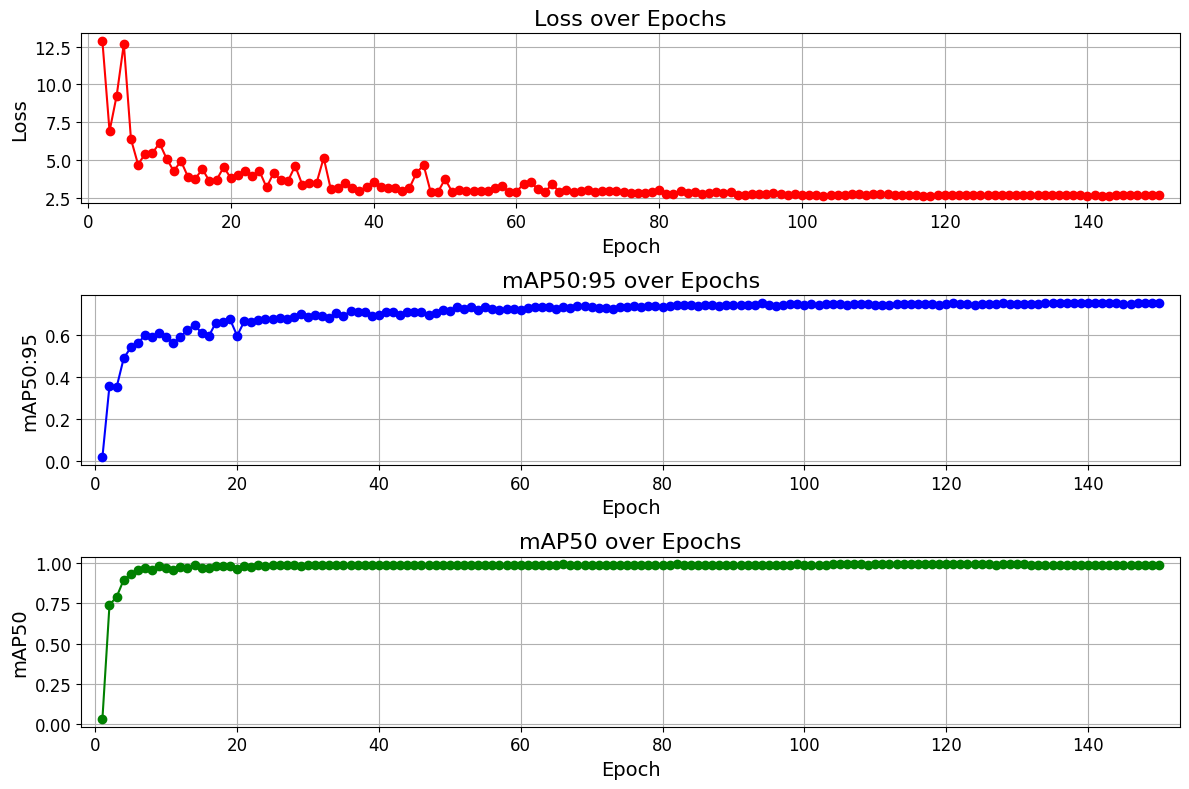

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import os
# Path to the CSV file
csv_path = r"C:\Users\admin\Desktop\thesisalgos\runs\detect\train9\results.csv"

# Load CSV data
data = pd.read_csv(csv_path)

# Calculate val loss as sum of val box, cls, dfl losses
val_loss = data['val/box_loss'] + data['val/cls_loss'] + data['val/dfl_loss']

# Extract other metrics
epochs = data['epoch']
map_50_95 = data['metrics/mAP50-95(B)']
ap50 = data['metrics/mAP50(B)']

# Plotting
plt.figure(figsize=(12, 8))

# Plot val loss (named Loss)
plt.subplot(3, 1, 1)
plt.plot(epochs, val_loss, marker='o', color='red')
plt.margins(x=0.02)
plt.title('Loss over Epochs',fontsize=16)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Plot mAP@[.5:.95]
plt.subplot(3, 1, 2)
plt.plot(epochs, map_50_95, marker='o', color='blue')
plt.margins(x=0.02)
plt.title('mAP50:95 over Epochs',fontsize=16)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('mAP50:95',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Plot AP50
plt.subplot(3, 1, 3)
plt.plot(epochs, ap50, marker='o', color='green')
plt.margins(x=0.02)
plt.title('mAP50 over Epochs',fontsize=16)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('mAP50',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

plt.tight_layout()

# Save plot to same directory as CSV file
out_dir = os.path.dirname(csv_path)
svg_path = os.path.join(out_dir, "training_metrics_yolo11_plot.svg")
plt.savefig(svg_path, format='svg')

plt.show()



Plot saved as C:\Users\admin\Desktop\thesisalgos\training_metrics_fasterrcnn_plot.png


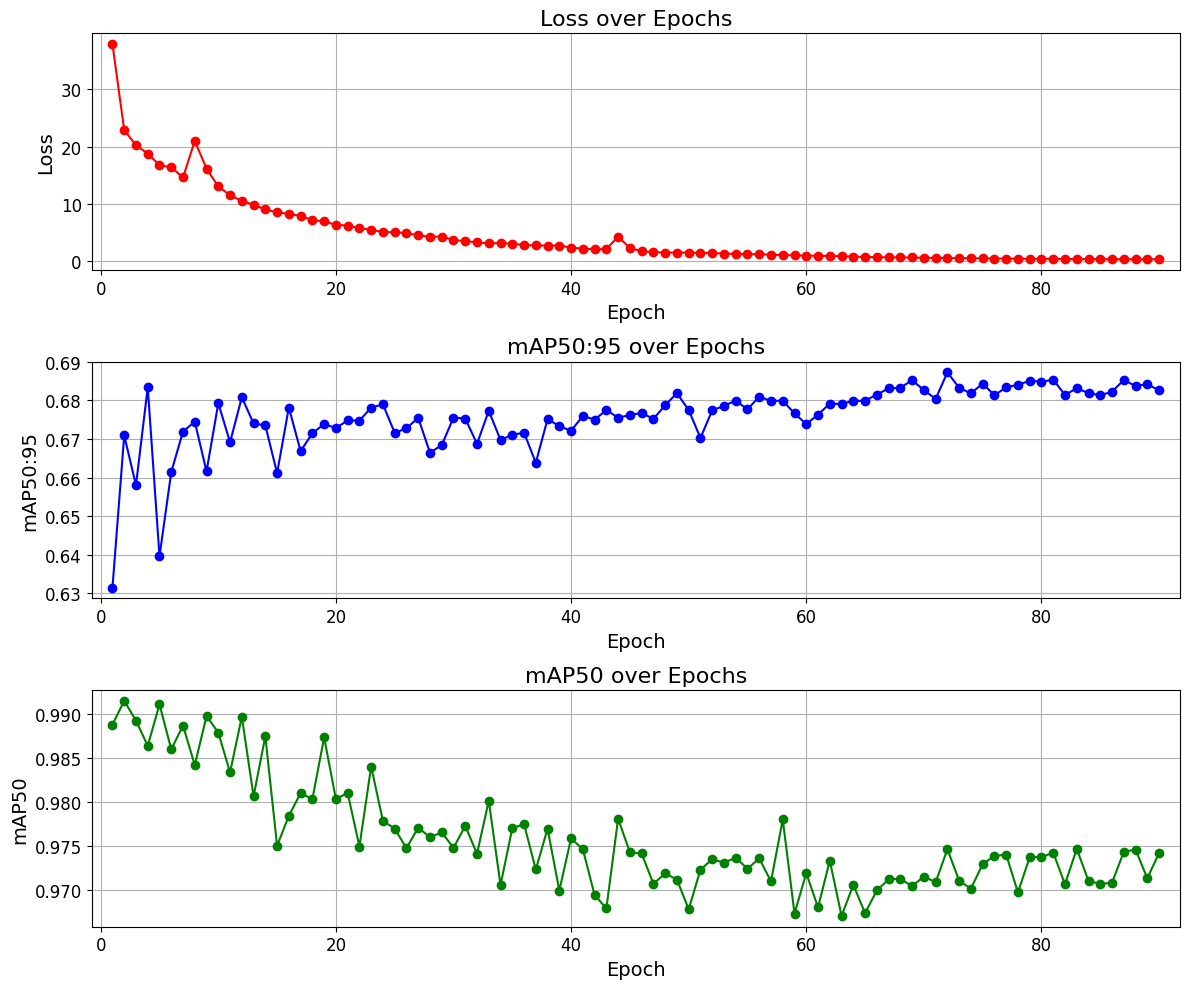

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the CSV file you logged in your Faster R-CNN script
csv_path = r"C:\Users\admin\Desktop\thesisalgos\metrics_log.csv"

# Load CSV data
data = pd.read_csv(csv_path)

# Extract columns
epochs = data['epoch']
train_loss = data['loss']
map_50_95 = data['mAP@[.5:.95]']
ap50 = data['AP50']
ap75 = data['AP75']

# Plotting
plt.figure(figsize=(12, 10))

# Plot training loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_loss, marker='o', color='red')
plt.margins(x=0.02)
plt.title('Loss over Epochs',fontsize=16)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Plot mAP@[.5:.95]
plt.subplot(3, 1, 2)
plt.plot(epochs, map_50_95, marker='o', color='blue')
plt.margins(x=0.02)
plt.title('mAP50:95 over Epochs',fontsize=16)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('mAP50:95',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Plot AP50 and AP75
plt.subplot(3, 1, 3)
plt.plot(epochs, ap50, marker='o', color='green', label='AP50')
plt.margins(x=0.02)
plt.title('mAP50 over Epochs',fontsize=16)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('mAP50',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

plt.tight_layout()

# Save plot to same directory as CSV file
out_dir = os.path.dirname(csv_path)
svg_path = os.path.join(out_dir, "training_metrics_fasterrcnn_plot.svg")
plt.savefig(svg_path, format='svg')


plt.show()
